In [248]:
import SLiCAP as sl
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

sl.ini.ngspice = "ngspice"
EKVlib = 'SLiCAP_C18.lib'
# EKVlib = 'SLiCAP1.lib'

Lmax = 10e-6
Lmin = 0.18e-6
Wmax = 100e-6
Wmin = 0.22e-6

gridnumL = 1  # Number of points in each direction
gridnumW = 1  # Number of points in each direction

In [249]:
def createStep(device, biasPar, VS, Npts, Vdiff, Idiff, Istart):
    """
        A function to Generate current list.
        
        Parameters:
        device - includes device information: Reference designator, BISM lib, type, device name, W, L, M
        biasPar - Biasing Method ("IDS" or "VGS")
        VS - Source Voltage
        Npts - Number of points
        Vdiff - Volatge step size for "VGS" method
        Idiff - Current step size for "IDS" method
        Istart - Current step start position
    """
    if device.dev == "nch":
        if biasPar == "VGS":
            step = [VS, Npts, Vdiff]
        elif biasPar == "IDS":
            step = [Istart, Npts, Idiff]
    elif device.dev == "pch":
        if biasPar == "VGS":
            step = [VS, Npts, -Vdiff]
        elif biasPar == "IDS":
            step = [-Istart, Npts, -Idiff]
    return step

In [250]:
L_values = np.geomspace(Lmin, Lmax, gridnumL)
W_values = np.geomspace(Wmin, Wmax, gridnumW)
traces_dict = {}

refDes   = 'M1'                                 # Reference designator of MOS device
DEV      = 'pch'                                # MOS device name
LIB      = '.lib lib/log018.l TT'               # use this CMOS BSIM library from klass Bult (EE4520)
LIB      = '.lib lib/cr018gpii_v1d0.l TT'     # use this TSMC BSIM library
biasPar  = "IDS"                                # Choose biasing with "VGS" or with "IDS"
Npts     = 50                                   # Number of points
M        = 1                                    # Number of devices in parallel

# actually not relavant here
Vdiff    = 0.01
ID       = 1E-6                      # Drain current single point, if not use 'step' in function 'getOPid'

VP       = 1.8
VS       = 0
VD       = 0.9
VB       = 0


if DEV == "pch":
    VS = VP
    VB = VP
    VD = VP - VD

vgs_sign = -1 if DEV == "pch" else 1
freq     = 1E5

if DEV == "nch":
    I0       = 6e-07                        # Approximated value of technology current to estmate current range
else:
    I0       = 8e-9                         # TBD (I_0 for PMOS)


for W_v in W_values:
    traces_dict[W_v] = {}
    
    for L_v in L_values:
        
        # IC = 0.01
        Imin = 0.01 * I0 * W_v / L_v
        # IC = 100
        Imax = 100* I0 * W_v / L_v

        # Create Current Step
        Idiff = (Imax - Imin) / Npts
        
        # Create the device and the current steps
        device = sl.MOS(refDes, LIB, DEV, W_v, L_v, M)
        step = createStep(device, biasPar, VS, Npts, Vdiff, Idiff, Imin)

        # use NGspice to get BSIM data
        device.getOPid(ID, VD, VS, VB, freq, step)

        derivedParams = {}
        derivedParams['fT'] = device.params['ggs']/(2*np.pi*device.params['cgg'])
        derivedParams['gmId'] = device.params['ggs']/device.params['i(ids)']
        # Store results in the nested dictionary
        traces_dict[W_v][L_v] = {
            'id': np.array(device.params['i(ids)'], dtype=float),
            'gm': np.array(device.params['ggs'], dtype=float),
            'gb': np.array(device.params['gbs'], dtype=float),
            'ft': np.array(derivedParams['fT'], dtype=float),
            'go': np.array(device.params['gdd'], dtype=float),
            'vgs': np.array(device.params['v(vgs)'], dtype=float)*vgs_sign,
            'gmId': np.array(derivedParams['gmId'], dtype=float)
        }

******
** ngspice-44.2 : Circuit level simulation program
** Compiled with KLU Direct Linear Solver
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2024, The ngspice team.
** Please get your ngspice manual from https://ngspice.sourceforge.io/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
******

Batch mode

Comments and warnings go to log-file: MOS_OP.log



In [251]:
prj = sl.initProject(f"BinkleyFitting")

Compiling library: SLiCAP.lib.
Compiling library: SLiCAPmodels.lib.


In [252]:
if device.dev == "nch":
    cirText = "EKV model\n.lib %s\nX1 D G S 0 CMOS18N W={W} L={L} ID={I_D} \n.param I_D=0 W=%s L=%s\n.end\n"%(EKVlib, device.W * device.M, device.L)
elif device.dev == "pch":
    cirText = "EKV model\n.lib %s\nX1 D G S 0 CMOS18P W={W} L={L} ID={-I_D} \n.param I_D=0 W=%s L=%s\n.end\n"%(EKVlib, device.W * device.M, device.L)
f = open('cir/MOS.cir', 'w')
f.write(cirText)
f.close()
cir = sl.makeCircuit('cir/MOS.cir', imgWidth=None)

Checking netlist: cir/MOS.cir
Compiling library: lib/SLiCAP_C18.lib.


In [253]:
def expand_expression(cir, expr_name):
    q             = 1.60217662e-19      # Electron charge in [C]
    c             = 2.99792458e+08      # Speed of light in [m/s]
    mu_0          = 4*np.pi*1e-7        # Permeability of vacuum in [H/m]
    epsilon_SiO2  = 3.9                 # Relative permittivity of SiO2 [-]
    k             = 1.38064852e-23      # Boltzmann constant in [J/K]
    epsilon_0     = 1/mu_0/c**2         # permittivity of vacuum in [F/m]
    T             = 300
    Ut            = k*T/q
    
    constants = {
        'q': q,
        'c': c,
        'mu_0': mu_0,
        'epsilon_SiO2': epsilon_SiO2,
        'k': k,
        'epsilon_0': epsilon_0,
        'T': T,
        'U_T': Ut,
        'Ut': Ut
    }
    
    expr = cir.getParValue(expr_name, False)
    
    if not hasattr(expr, 'free_symbols'):
        return expr
    
    changed = True
    while changed:
        changed = False
        for sym in list(expr.free_symbols):
            sym_name = str(sym)
            
            if sym_name in constants:
                expr = expr.subs(sym, constants[sym_name])
                changed = True
                continue
            
            try:
                sym_value = cir.getParValue(sym_name, False)
                if isinstance(sym_value, (int, float)) or sym_value.is_number:
                    continue
                if sym_value != sym:
                    expr = expr.subs(sym, sym_value)
                    changed = True
            except:
                pass
    
    return expr

In [254]:
g_m = expand_expression(cir, 'g_m_X1')
g_b = expand_expression(cir, 'g_b_X1')
V_GS = expand_expression(cir, 'V_GS_X1')

In [255]:
symbols = list(V_GS.free_symbols)

In [256]:
def create_numeric_function(expr, symbols):
    """
        A function to lambdify the expresion
        
        Parameters:
        expr - expression in SymPy
        symbols - symbols in the expr
    """
    func = sp.lambdify(symbols, expr, modules=['numpy', {'sqrt': np.sqrt}])
    
    # error considerations
    def safe_func(*args):
        try:
            result = func(*args)
        
            if np.isfinite(result) and not np.isnan(result):
                return float(result)
            else:
                print(f"Warning: Calculation null: {result}")
                return 1.0
        except Exception as e:
            print(f"Calculation error: {e} (parameters: {args})")
            return 1.0
    return safe_func

In [257]:
g_m_func  = create_numeric_function(g_m, symbols)
g_b_func  = create_numeric_function(g_b, symbols)
vgs_func = create_numeric_function(V_GS, symbols)

In [258]:
symbols

[TOX_P18, I_D, L, Vth_P18, N_s_P18, E_CRIT_P18, W, Theta_P18, u_0_P18]

In [259]:
class MultiDimensionEKVFittingProblem(Problem):
    def __init__(self, w_values, l_values, traces_dict, g_m_expr, g_b_expr, V_GS_expr, device_type='nch'):
        """
        Initialize multi-dimensional EKV fitting problem
        
        Parameters:
        w_values - List of W values to optimize for
        l_values - List of L values to optimize for
        traces_dict - Nested dictionary with format {W: {L: {parameter_data}}}
        g_m_expr, g_b_expr, V_GS_expr - SymPy expressions
        device_type - 'nch' or 'pch'
        """
        self.device_type = device_type
        
        # Collect all symbols from the expressions
        all_symbols = g_m_expr.free_symbols | g_b_expr.free_symbols | V_GS_expr.free_symbols
        self.all_symbols = sorted(all_symbols, key=lambda x: str(x))
        
        # Classify symbols: fixed vs fitting
        # Fixed parameters
        self.fixed_params = ['L', 'W', 'I_D', 'TOX_N18' if device_type == 'nch' else 'TOX_P18']
        
        # Fitting parameters (optimization variables) - determined by device type suffix
        suffix = '_N18' if device_type == 'nch' else '_P18'
        
        # Check if beta is present in the expressions
        self.has_beta = any(f'beta{suffix}' in str(sym) for sym in self.all_symbols)
        
        # Base fitting parameters
        self.fitting_params = [
            f'Theta{suffix}',
            f'u_0{suffix}',
            f'E_CRIT{suffix}',
            f'N_s{suffix}',
            f'Vth{suffix}'
        ]
        
        # Add beta if present in expressions
        if self.has_beta:
            self.fitting_params.append(f'beta{suffix}')
            n_var = 6
            # Boundaries: [Theta, u_0, E_CRIT, N_s, Vth, beta]
            if device_type == 'nch':
                xl = np.array([0.2, 0.001, 1e6, 1.20, 0.4, 0.5])
                xu = np.array([0.5, 0.2, 20e6, 1.6, 0.5, 1.5])
            else:
                xl = np.array([0.2, 0.001, 2e6, 1.20, -0.6, 0.5])
                xu = np.array([0.5, 0.2, 40e6, 1.6, -0.4, 1.5])
        else:
            n_var = 5
            # Boundaries: [Theta, u_0, E_CRIT, N_s, Vth]
            if device_type == 'nch':
                xl = np.array([0.2, 0.001, 1e6, 1.20, 0.4])
                xu = np.array([0.5, 0.2, 20e6, 1.6, 0.5])
            else:
                xl = np.array([0.2, 0.001, 2e6, 1.20, -0.6])
                xu = np.array([0.5, 0.2, 40e6, 1.6, -0.4])
        
        super().__init__(n_var=n_var, n_obj=3, n_constr=0, elementwise_evaluation=False)
        
        self.xl = xl
        self.xu = xu

        self.symbol_name_map = {str(sym): sym for sym in self.all_symbols}
        
        # Create lambdify functions using the fixed symbol order
        self.g_m_func = sp.lambdify(self.all_symbols, g_m_expr, modules=['numpy', {'sqrt': np.sqrt}])
        self.g_b_func = sp.lambdify(self.all_symbols, g_b_expr, modules=['numpy', {'sqrt': np.sqrt}])
        self.vgs_func = sp.lambdify(self.all_symbols, V_GS_expr, modules=['numpy', {'sqrt': np.sqrt}])
        
        # Print symbol order for reference
        print(f"Symbol order: {[str(s) for s in self.all_symbols]}")
        print(f"Fitting params: {self.fitting_params}")
        print(f"Beta parameter detected: {self.has_beta}")

        # Define fixed parameters
        self.TOX = 4.1e-9 if device_type == 'nch' else 4.1e-9
        self.w_values = w_values
        self.l_values = l_values
        self.traces_dict = traces_dict

    def _build_args(self, fitting_vals, W, L, I_D):
        """
        Build argument list for the lambdified functions based on symbol order
        fitting_vals: [Theta, u_0, E_CRIT, N_s, Vth] or [Theta, u_0, E_CRIT, N_s, Vth, beta]
        """
        suffix = '_N18' if self.device_type == 'nch' else '_P18'
        
        # Create parameter values dictionary
        param_values = {
            'L': L,
            'W': W,
            'I_D': I_D,
            f'TOX{suffix}': self.TOX,
            f'Theta{suffix}': fitting_vals[0],
            f'u_0{suffix}': fitting_vals[1],
            f'E_CRIT{suffix}': fitting_vals[2],
            f'N_s{suffix}': fitting_vals[3],
            f'Vth{suffix}': fitting_vals[4]
        }
        
        # Add beta if present
        if self.has_beta:
            param_values[f'beta{suffix}'] = fitting_vals[5]
        
        args = []
        for sym in self.all_symbols:
            sym_name = str(sym)
            if sym_name in param_values:
                args.append(param_values[sym_name])
            else:
                raise ValueError(f"Unknown symbol: {sym_name}")
        
        return args

    def _evaluate(self, X, out, *args, **kwargs):
        """
        Evaluate model fitting errors across multiple W and L values
        """
        n_points = X.shape[0]
        F = np.zeros((n_points, 3))  # n_obj = 3 (VGS, gm, gb)
        
        for i in range(n_points):
            try:
                fitting_vals = X[i]  # [Theta, u_0, E_CRIT, N_s, Vth] or with beta
                
                # Initialize error accumulators
                all_errors = {'gm': [], 'gb': [], 'vgs': []}
                
                # Iterate through all W,L combinations
                for W in self.w_values:
                    for L in self.l_values:
                        traces = self.traces_dict[W][L]
                        
                        id_data = traces['id']
                        gm_data = traces['gm']
                        gb_data = traces['gb']
                        vgs_data = traces['vgs']
                        
                        # Process each ID point
                        for j, id_val in enumerate(id_data):
                            try:
                                # Build exact parameter list
                                func_args = self._build_args(fitting_vals, W, L, id_val)
                                
                                gm_pred = self.g_m_func(*func_args)
                                gb_pred = self.g_b_func(*func_args)
                                vgs_pred = self.vgs_func(*func_args)
                                
                                # Calculate relative errors
                                if np.isfinite(gm_pred) and gm_data[j] != 0:
                                    all_errors['gm'].append(((gm_pred - gm_data[j]) / gm_data[j])**2)
                                if np.isfinite(gb_pred) and gb_data[j] != 0:
                                    all_errors['gb'].append(((gb_pred - gb_data[j]) / gb_data[j])**2)
                                if np.isfinite(vgs_pred) and vgs_data[j] != 0:
                                    all_errors['vgs'].append(((vgs_pred - vgs_data[j]) / vgs_data[j])**2)
                            except Exception as e:
                                continue
                
                # Calculate RMSE
                f1 = np.sqrt(np.mean(all_errors['gm'])) if all_errors['gm'] else 1e10
                f2 = np.sqrt(np.mean(all_errors['gb'])) if all_errors['gb'] else 1e10
                f3 = np.sqrt(np.mean(all_errors['vgs'])) if all_errors['vgs'] else 1e10
                F[i] = [f1, f2, f3]

            except Exception as e:
                print(f"Parameter {i} error: {e}")
                F[i] = [1e10, 1e10, 1e10]
        
        out["F"] = F

In [260]:
problem = MultiDimensionEKVFittingProblem(W_values, L_values, traces_dict, g_m, g_b, V_GS, device.dev)

Symbol order: ['E_CRIT_P18', 'I_D', 'L', 'N_s_P18', 'TOX_P18', 'Theta_P18', 'Vth_P18', 'W', 'u_0_P18']
Fitting params: ['Theta_P18', 'u_0_P18', 'E_CRIT_P18', 'N_s_P18', 'Vth_P18']
Beta parameter detected: False


In [261]:
# [Theta, u_0, E_CRIT, N_s, Vth]
#test_point = np.array([0.3, 50e-3, 8e6, 1.3, 0.4, 0.8])
#result = problem.evaluate(test_point)
#result

In [262]:
sampling = LHS()

algorithm = NSGA2(
    pop_size=150,
    n_offsprings=45,
    sampling=sampling,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

optimal_solutions = res.X
optimal_objectives = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |     11 |             - |             -
     2 |      195 |     13 |  0.0067992165 |             f
     3 |      240 |     18 |  0.0108922832 |         ideal
     4 |      285 |     19 |  0.0068480168 |         ideal
     5 |      330 |     26 |  0.0198823441 |         ideal
     6 |      375 |     36 |  0.0177425819 |             f
     7 |      420 |     12 |  0.0539704593 |         ideal
     8 |      465 |      9 |  0.1036736591 |             f
     9 |      510 |     14 |  0.0097509783 |         ideal
    10 |      555 |     15 |  0.0046474622 |             f
    11 |      600 |     26 |  0.0301975362 |             f
    12 |      645 |     29 |  0.0133762916 |         ideal
    13 |      690 |     24 |  0.0051249974 |         ideal
    14 |      735 |     25 |  0.0113241837 |             f
    15 |      780 |     26 |  0.3385142222 |         nadir
    16 |      825 |     23 |  0.3291181310 |         nad

## Inspect parameter distribution

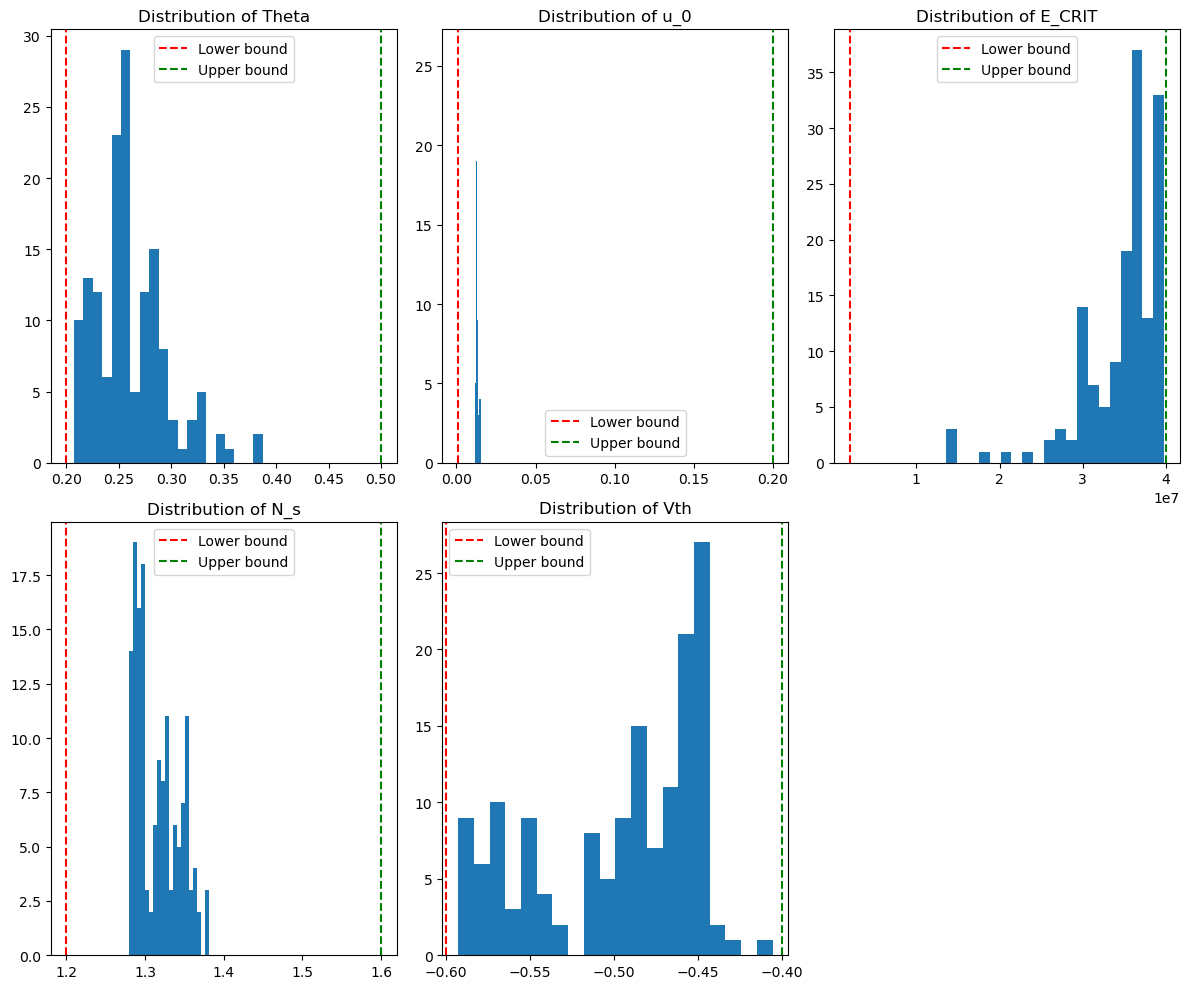

In [263]:
# Parameter distribution visualization
# Order matches fitting_params: [Theta, u_0, E_CRIT, N_s, Vth] or [Theta, u_0, E_CRIT, N_s, Vth, beta]
if problem.has_beta:
    param_names = ["Theta", "u_0", "E_CRIT", "N_s", "Vth", "beta"]
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
else:
    param_names = ["Theta", "u_0", "E_CRIT", "N_s", "Vth"]
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    
axes = axes.flatten()

for i, name in enumerate(param_names):
    axes[i].hist(optimal_solutions[:, i], bins=20)
    axes[i].set_title(f'Distribution of {name}')
    axes[i].axvline(problem.xl[i], color='r', linestyle='--', label='Lower bound')
    axes[i].axvline(problem.xu[i], color='g', linestyle='--', label='Upper bound')
    axes[i].legend()

# Remove empty subplots
for i in range(len(param_names), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Weighing Solutions

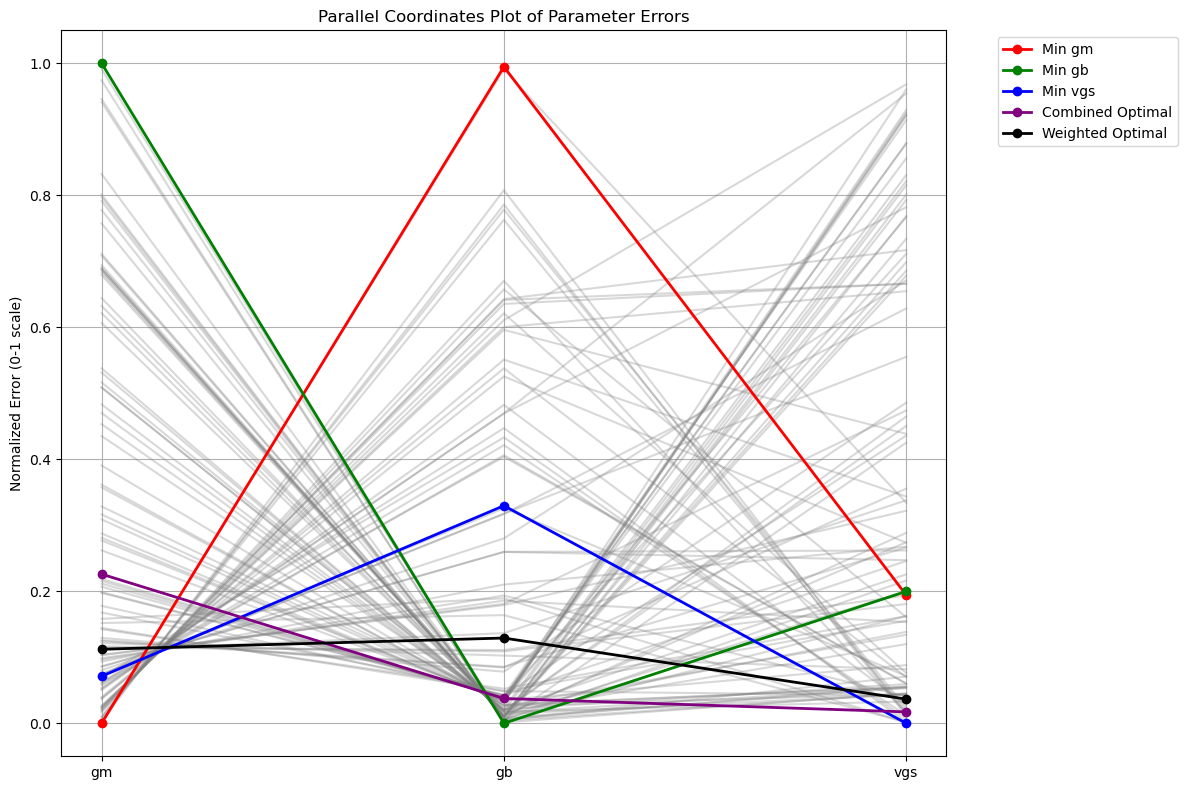


Selected best solution (using weighted error):
Theta_P18: 2.768246e-01
u_0_P18: 1.232038e-02
E_CRIT_P18: 3.692678e+07
N_s_P18: 1.314838
Vth_P18: -4.505530e-01
Weighted combined error: 0.016433
Euclidean distance error: 0.048481


In [264]:
errors_params = optimal_objectives[:, :3]  # gm, gb, vgs

# Calculate Euclidean distance
combined_error = np.sqrt(np.sum(np.square(errors_params), axis=1))

# Custom weights: gm, gb, vgs
weights = np.array([10.0, 1.0, 0.5])
weights = weights / np.sum(weights)
weighted_combined_error = np.sum(weights * errors_params, axis=1)

# Find optimal solutions
min_combined_idx = np.argmin(combined_error)
min_weighted_idx = np.argmin(weighted_combined_error)

# Find minimum for each objective
min_indices = [np.argmin(optimal_objectives[:, i]) for i in range(3)]
obj_names = ["gm", "gb", "vgs"]

# Visualization
plt.figure(figsize=(12, 8))

num_solutions_to_plot = min(100, len(optimal_objectives))
indices_to_plot = np.random.choice(len(optimal_objectives), num_solutions_to_plot, replace=False)

special_indices = np.concatenate([min_indices, [min_combined_idx, min_weighted_idx]])
indices_to_plot = np.unique(np.concatenate([indices_to_plot, special_indices]))

param_errors = errors_params[indices_to_plot]

normalized_errors = (param_errors - np.min(errors_params, axis=0)) / (np.max(errors_params, axis=0) - np.min(errors_params, axis=0))

x = np.arange(3)

for i, idx in enumerate(indices_to_plot):
    if idx not in special_indices:
        plt.plot(x, normalized_errors[i], 'gray', alpha=0.3)

colors = ['red', 'green', 'blue', 'purple', 'black']
labels = [f"Min {param}" for param in obj_names] + ["Combined Optimal", "Weighted Optimal"]

for i, idx in enumerate(special_indices):
    plot_idx = np.where(indices_to_plot == idx)[0][0]
    plt.plot(x, normalized_errors[plot_idx], marker='o', color=colors[i], linewidth=2, label=labels[i])

plt.xticks(x, obj_names)
plt.ylabel('Normalized Error (0-1 scale)')
plt.title('Parallel Coordinates Plot of Parameter Errors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract best solution parameters
best_idx = min_weighted_idx
best_solution = optimal_solutions[min_weighted_idx]

# Extract parameters based on whether beta is present
Theta_best = best_solution[0]
u_0_best = best_solution[1]
E_CRIT_best = best_solution[2]
N_s_best = best_solution[3]
Vth_best = best_solution[4]

if problem.has_beta:
    beta_best = best_solution[5]
else:
    beta_best = None

suffix = '_N18' if problem.device_type == 'nch' else '_P18'

print(f"\nSelected best solution (using weighted error):")
print(f"Theta{suffix}: {Theta_best:.6e}")
print(f"u_0{suffix}: {u_0_best:.6e}")
print(f"E_CRIT{suffix}: {E_CRIT_best:.6e}")
print(f"N_s{suffix}: {N_s_best:.6f}")
print(f"Vth{suffix}: {Vth_best:.6e}")
if problem.has_beta:
    print(f"beta{suffix}: {beta_best:.6e}")
print(f"Weighted combined error: {weighted_combined_error[min_weighted_idx]:.6f}")
print(f"Euclidean distance error: {combined_error[min_weighted_idx]:.6f}")

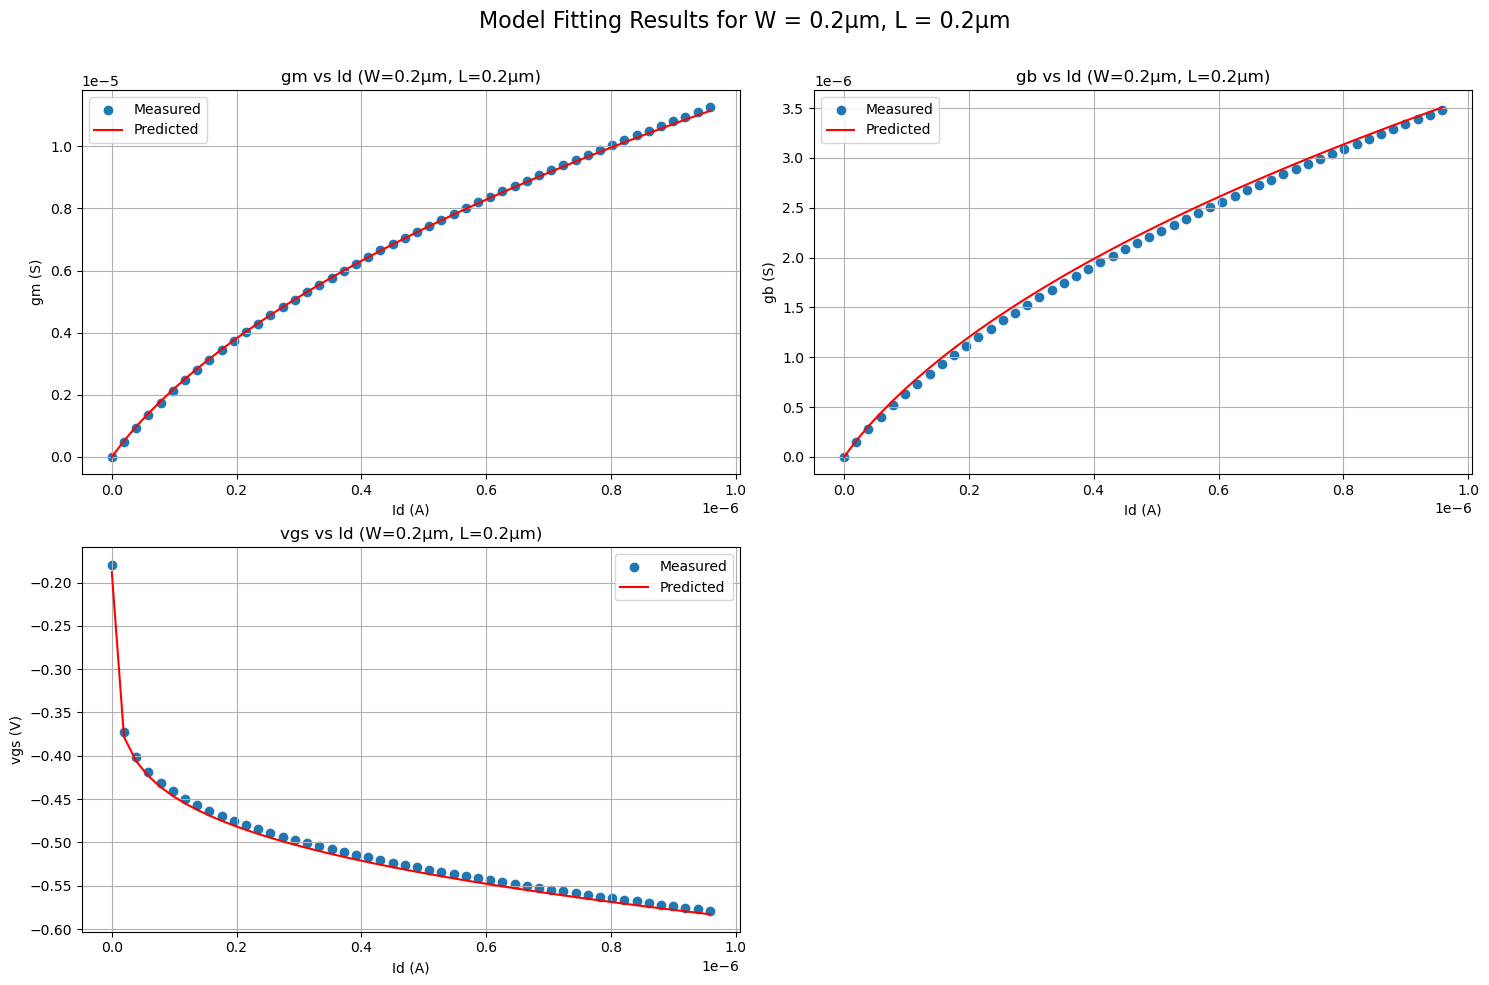

In [265]:
# Generate predictions using best solution
predictions = {}

for W in problem.w_values:
    predictions[W] = {}
    
    for L in problem.l_values:
        traces = problem.traces_dict[W][L]
        
        id_data = traces['id']
        gm_data = traces['gm']
        gb_data = traces['gb']
        vgs_data = traces['vgs']
        
        gm_pred = []
        gb_pred = []
        vgs_pred = []
        
        # Build fitting_vals in correct order: [Theta, u_0, E_CRIT, N_s, Vth] or with beta
        if problem.has_beta:
            fitting_vals = [Theta_best, u_0_best, E_CRIT_best, N_s_best, Vth_best, beta_best]
        else:
            fitting_vals = [Theta_best, u_0_best, E_CRIT_best, N_s_best, Vth_best]
        
        for id_val in id_data:
            try:
                func_args = problem._build_args(fitting_vals, W, L, id_val)
                
                gm_val = problem.g_m_func(*func_args)
                gb_val = problem.g_b_func(*func_args)
                vgs_val = problem.vgs_func(*func_args)
                
                gm_pred.append(gm_val)
                gb_pred.append(gb_val)
                vgs_pred.append(vgs_val)
            except Exception as e:
                gm_pred.append(None)
                gb_pred.append(None)
                vgs_pred.append(None)
        
        # Filter valid indices
        valid_indices = [i for i in range(len(id_data)) 
                        if gm_pred[i] is not None and gb_pred[i] is not None and vgs_pred[i] is not None]
        
        valid_id = [id_data[i] for i in valid_indices]
        valid_gm_pred = [gm_pred[i] for i in valid_indices]
        valid_gb_pred = [gb_pred[i] for i in valid_indices]
        valid_vgs_pred = [vgs_pred[i] for i in valid_indices]
        
        valid_gm_data = [gm_data[i] for i in valid_indices]
        valid_gb_data = [gb_data[i] for i in valid_indices]
        valid_vgs_data = [vgs_data[i] for i in valid_indices]
        
        predictions[W][L] = {
            'id': valid_id,
            'gm_pred': valid_gm_pred,
            'gb_pred': valid_gb_pred,
            'vgs_pred': valid_vgs_pred,
            'gm_data': valid_gm_data,
            'gb_data': valid_gb_data,
            'vgs_data': valid_vgs_data
        }

# Visualize fitting results
for W in problem.w_values:
    for L in problem.l_values:
        pred = predictions[W][L]
        
        plt.figure(figsize=(15, 10))
        
        # gm fitting
        plt.subplot(2, 2, 1)
        plt.scatter(pred['id'], pred['gm_data'], label='Measured')
        plt.plot(pred['id'], pred['gm_pred'], 'r-', label='Predicted')
        plt.xlabel('Id (A)')
        plt.ylabel('gm (S)')
        plt.title(f'gm vs Id (W={W*1e6:.1f}μm, L={L*1e6:.1f}μm)')
        plt.legend()
        plt.grid(True)
        
        # gb fitting
        plt.subplot(2, 2, 2)
        plt.scatter(pred['id'], pred['gb_data'], label='Measured')
        plt.plot(pred['id'], pred['gb_pred'], 'r-', label='Predicted')
        plt.xlabel('Id (A)')
        plt.ylabel('gb (S)')
        plt.title(f'gb vs Id (W={W*1e6:.1f}μm, L={L*1e6:.1f}μm)')
        plt.legend()
        plt.grid(True)
        
        # vgs fitting
        plt.subplot(2, 2, 3)
        plt.scatter(pred['id'], pred['vgs_data'], label='Measured')
        plt.plot(pred['id'], pred['vgs_pred'], 'r-', label='Predicted')
        plt.xlabel('Id (A)')
        plt.ylabel('vgs (V)')
        plt.title(f'vgs vs Id (W={W*1e6:.1f}μm, L={L*1e6:.1f}μm)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.suptitle(f'Model Fitting Results for W = {W*1e6:.1f}μm, L = {L*1e6:.1f}μm', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

In [266]:
# Helper functions for error calculations
def calculate_relative_rmse(predicted, measured):
    """Calculate relative RMSE"""
    return np.sqrt(np.mean([((p-m)/m)**2 for p, m in zip(predicted, measured)]))

def calculate_mape(predicted, measured):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean([np.abs((p-m)/m)*100 for p, m in zip(predicted, measured)])

def calculate_mae(predicted, measured):
    """Calculate Mean Absolute Error"""
    return np.mean([np.abs(p-m) for p, m in zip(predicted, measured)])

In [267]:
# Calculate error metrics for each W,L combination
error_metrics = {}

for W in problem.w_values:
    error_metrics[W] = {}
    
    for L in problem.l_values:
        pred = predictions[W][L]
        
        params = ['gm', 'gb', 'vgs']
        metrics = {}
        
        for param in params:
            pred_values = pred[f'{param}_pred']
            data_values = pred[f'{param}_data']
            
            metrics[f'{param}_rmse'] = calculate_relative_rmse(pred_values, data_values)
            metrics[f'{param}_mape'] = calculate_mape(pred_values, data_values)
            metrics[f'{param}_mae'] = calculate_mae(pred_values, data_values)
        
        # Combined errors
        rmse_values = [metrics[f'{param}_rmse'] for param in params]
        mape_values = [metrics[f'{param}_mape'] for param in params]
        
        metrics['combined_rmse'] = np.sqrt(np.sum(np.square(rmse_values)))
        metrics['combined_mape'] = np.mean(mape_values)
        
        error_metrics[W][L] = metrics

# Print summary
print("\nError metrics summary:")
print(f"{'W (μm)':10} {'L (μm)':10} {'Combined RMSE (%)':18} {'Combined MAPE (%)':18}")
print("-" * 60)

for W in problem.w_values:
    for L in problem.l_values:
        metrics = error_metrics[W][L]
        w_str = f"{W*1e6:.1f}"
        l_str = f"{L*1e6:.3f}"
        rmse = metrics['combined_rmse'] * 100
        mape = metrics['combined_mape']
        print(f"{w_str:10} {l_str:10} {rmse:18.2f} {mape:18.2f}")

# Overall assessment
all_combined_rmse = [metrics['combined_rmse'] for W in error_metrics for metrics in error_metrics[W].values()]
all_combined_mape = [metrics['combined_mape'] for W in error_metrics for metrics in error_metrics[W].values()]

avg_combined_rmse = np.mean(all_combined_rmse)
avg_combined_mape = np.mean(all_combined_mape)

print(f"\nAverage combined RMSE across all sizes: {avg_combined_rmse*100:.2f}%")
print(f"Average combined MAPE across all sizes: {avg_combined_mape:.2f}%")


Error metrics summary:
W (μm)     L (μm)     Combined RMSE (%)  Combined MAPE (%) 
------------------------------------------------------------
0.2        0.180                    4.85               1.90

Average combined RMSE across all sizes: 4.85%
Average combined MAPE across all sizes: 1.90%


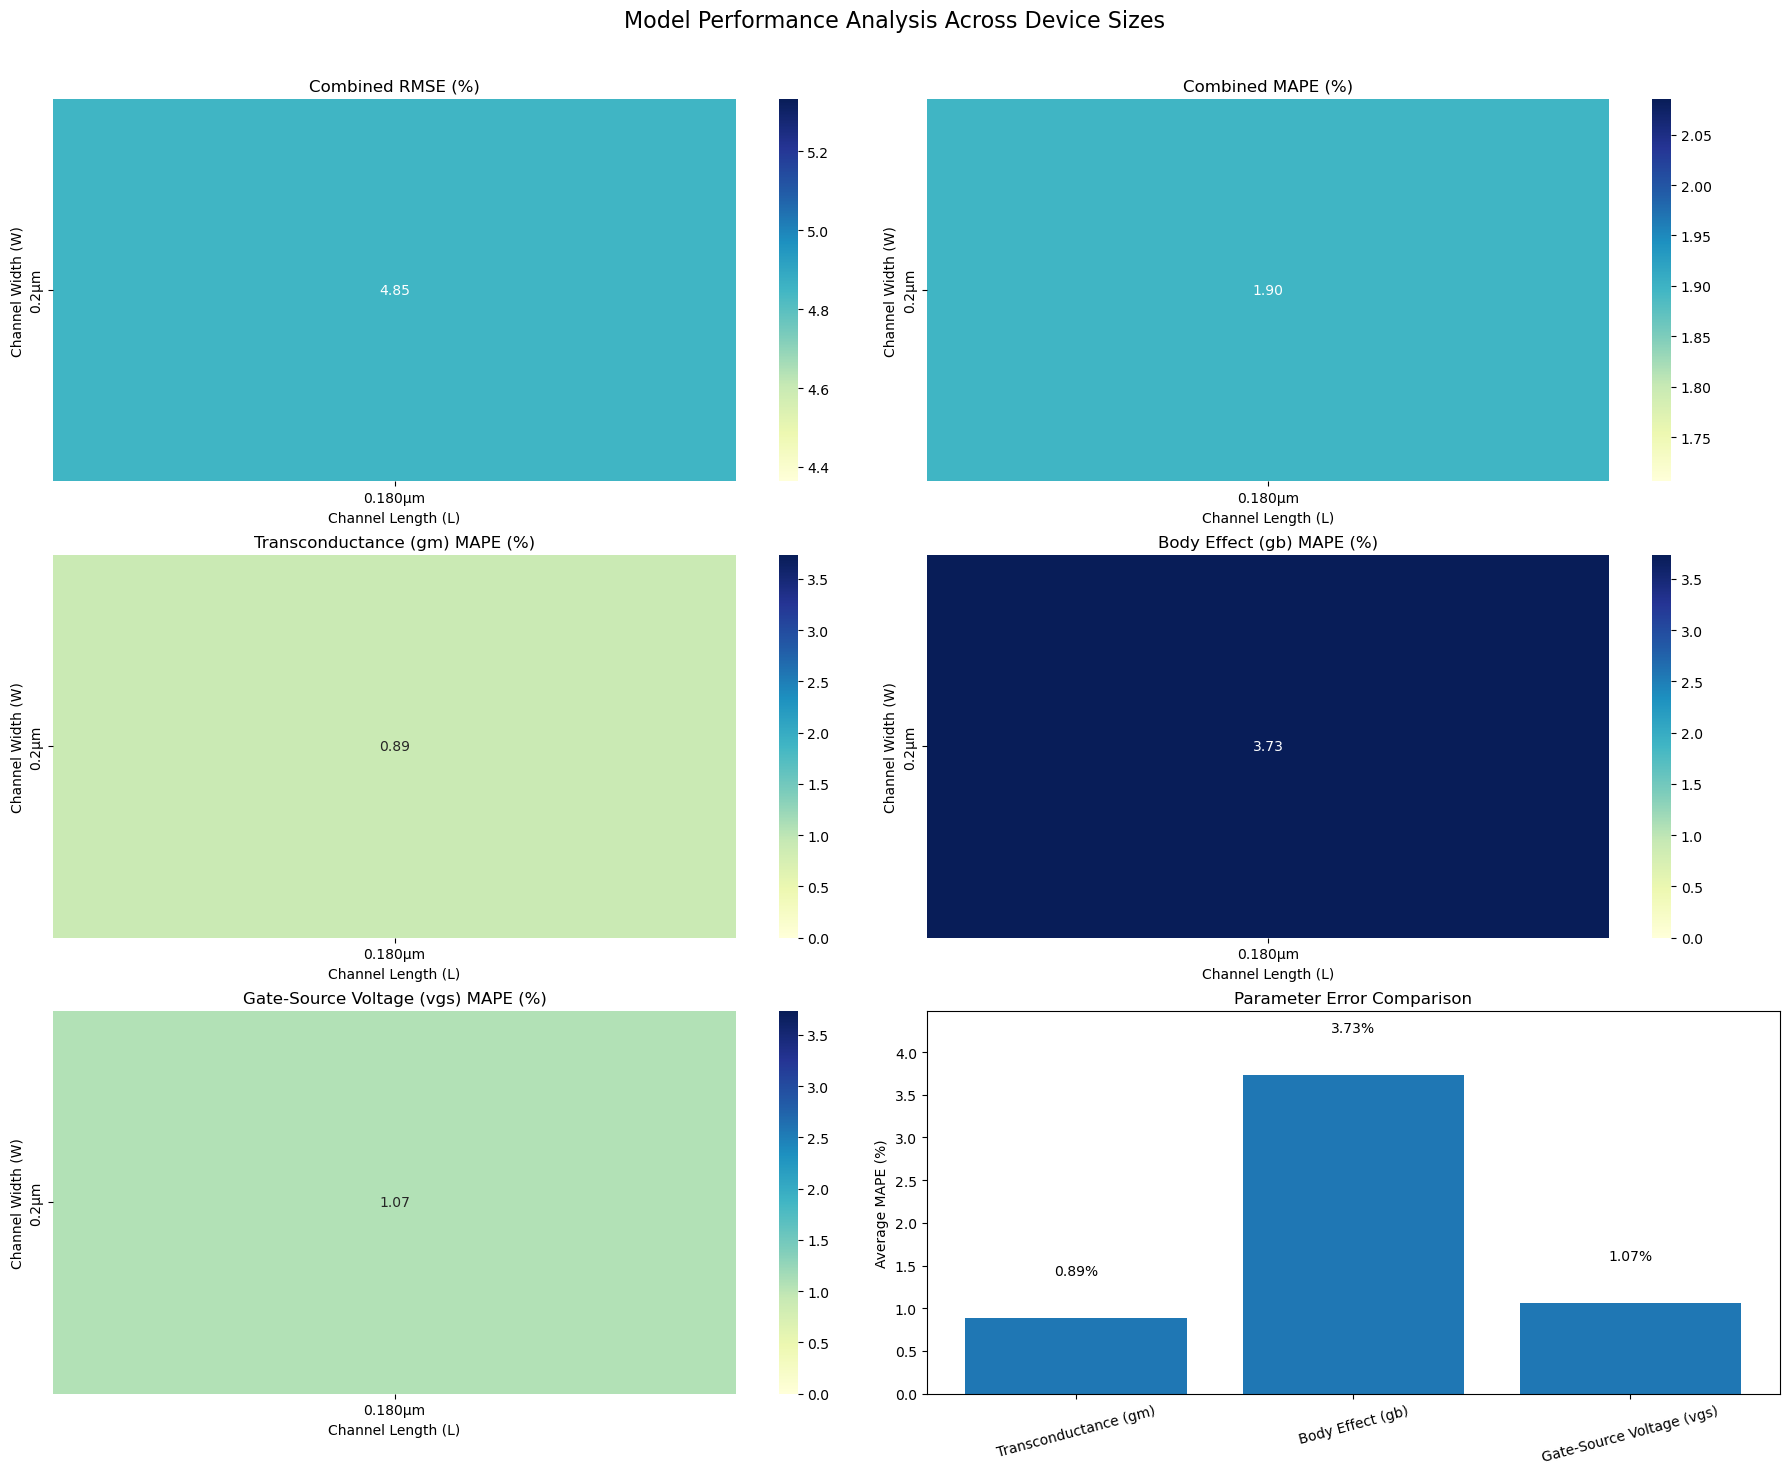

In [268]:
# MAPE heatmaps visualization
plt.figure(figsize=(18, 15))

w_labels = [f"{W*1e6:.1f}μm" for W in problem.w_values]
l_labels = [f"{L*1e6:.3f}μm" for L in problem.l_values]

# Combined RMSE and MAPE heatmaps
rmse_data = np.array([[error_metrics[W][L]['combined_rmse'] * 100 
                      for L in problem.l_values] 
                      for W in problem.w_values])

mape_data = np.array([[error_metrics[W][L]['combined_mape'] 
                      for L in problem.l_values] 
                      for W in problem.w_values])

# Individual parameter MAPE data
gm_mape_data = np.array([[error_metrics[W][L]['gm_mape'] 
                          for L in problem.l_values] 
                          for W in problem.w_values])

gb_mape_data = np.array([[error_metrics[W][L]['gb_mape'] 
                          for L in problem.l_values] 
                          for W in problem.w_values])

vgs_mape_data = np.array([[error_metrics[W][L]['vgs_mape'] 
                           for L in problem.l_values] 
                           for W in problem.w_values])

max_mape = max(np.max(gm_mape_data), np.max(gb_mape_data), np.max(vgs_mape_data))
vmin = 0
vmax = min(max_mape, max_mape * 1.2)

# Plot combined RMSE
plt.subplot(3, 2, 1)
sns.heatmap(rmse_data, annot=True, fmt=".2f", xticklabels=l_labels, yticklabels=w_labels, cmap="YlGnBu")
plt.xlabel('Channel Length (L)')
plt.ylabel('Channel Width (W)')
plt.title('Combined RMSE (%)')

# Plot combined MAPE
plt.subplot(3, 2, 2)
sns.heatmap(mape_data, annot=True, fmt=".2f", xticklabels=l_labels, yticklabels=w_labels, cmap="YlGnBu")
plt.xlabel('Channel Length (L)')
plt.ylabel('Channel Width (W)')
plt.title('Combined MAPE (%)')

# Plot gm MAPE
plt.subplot(3, 2, 3)
sns.heatmap(gm_mape_data, annot=True, fmt=".2f", xticklabels=l_labels, yticklabels=w_labels, 
            cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.xlabel('Channel Length (L)')
plt.ylabel('Channel Width (W)')
plt.title('Transconductance (gm) MAPE (%)')

# Plot gb MAPE
plt.subplot(3, 2, 4)
sns.heatmap(gb_mape_data, annot=True, fmt=".2f", xticklabels=l_labels, yticklabels=w_labels, 
            cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.xlabel('Channel Length (L)')
plt.ylabel('Channel Width (W)')
plt.title('Body Effect (gb) MAPE (%)')

# Plot vgs MAPE
plt.subplot(3, 2, 5)
sns.heatmap(vgs_mape_data, annot=True, fmt=".2f", xticklabels=l_labels, yticklabels=w_labels, 
            cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.xlabel('Channel Length (L)')
plt.ylabel('Channel Width (W)')
plt.title('Gate-Source Voltage (vgs) MAPE (%)')

# Parameter error comparison bar chart
params = ['gm', 'gb', 'vgs']
param_titles = ['Transconductance (gm)', 'Body Effect (gb)', 'Gate-Source Voltage (vgs)']

param_mape_avg = []
for param in params:
    values = [error_metrics[W][L][f'{param}_mape'] 
              for W in problem.w_values 
              for L in problem.l_values]
    param_mape_avg.append(np.mean(values))

plt.subplot(3, 2, 6)
bars = plt.bar(param_titles, param_mape_avg)
plt.ylabel('Average MAPE (%)')
plt.title('Parameter Error Comparison')
plt.xticks(rotation=15)
plt.ylim(0, max(param_mape_avg) * 1.2)

for bar, val in zip(bars, param_mape_avg):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f"{val:.2f}%", ha='center')

plt.tight_layout()
plt.suptitle('Model Performance Analysis Across Device Sizes', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

In [269]:
# Save best parameters to file
suffix = 'N18' if problem.device_type == 'nch' else 'P18'

with open(f'ekv_parameters_{problem.device_type}_{suffix}.txt', 'w') as f:
    f.write(f"Theta{suffix} = {Theta_best}\n")
    f.write(f"u_0{suffix} = {u_0_best}\n")
    f.write(f"E_CRIT{suffix} = {E_CRIT_best}\n")
    f.write(f"N_s{suffix} = {N_s_best}\n")
    f.write(f"Vth{suffix} = {Vth_best}\n")
    if problem.has_beta:
        f.write(f"beta{suffix} = {beta_best}\n")

print(f"\nSelected best solution:")
print(f"Theta{suffix}: {Theta_best:.6e}")
print(f"u_0{suffix}: {u_0_best:.6e}")
print(f"E_CRIT{suffix}: {E_CRIT_best:.6e}")
print(f"N_s{suffix}: {N_s_best:.6f}")
print(f"Vth{suffix}: {Vth_best:.6e}")
if problem.has_beta:
    print(f"beta{suffix}: {beta_best:.6e}")
print(f"\nParameters saved to 'ekv_parameters_{problem.device_type}_{suffix}.txt'")


Selected best solution:
ThetaP18: 2.768246e-01
u_0P18: 1.232038e-02
E_CRITP18: 3.692678e+07
N_sP18: 1.314838
VthP18: -4.505530e-01

Parameters saved to 'ekv_parameters_pch_P18.txt'
